In [1]:
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset

from tqdm import tqdm
import neptune
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
#config

print(torch.__version__)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


os.environ["NEPTUNE_API_TOKEN"] ="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyMWUxNDAwOS04NGFmLTQ1NDEtYTliYi0zOTRkYmFkOTFiNzMifQ=="

neptune_run = neptune.init_run(
    project="jayasooryantm/xai-medical-imaging",
    api_token=os.environ.get("NEPTUNE_API_TOKEN"),
)


2.5.0.dev20240619
Using device: mps


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/jayasooryantm/xai-medical-imaging/e/XAIM-16


In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.224])
])


In [4]:
train_dir = "../chest_xray/train"


In [5]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)


In [6]:
len(train_dataset)


5216

In [7]:
def dataset_validator():
    """
    Cross varifying the image and the target variables are correct.
    """
    validation_status = True

    for img_path, target in train_dataset.imgs:
        if img_path.split("/")[3] == "NORMAL":
            if target == 0:
                pass # img_path == target
            else:
                validation_status = False
                print(f"\n-----CHECK THIS----- \nImage Path: {img_path}, \nTarget Value: {target}")
        if img_path.split("/")[3] == "PNEUMONIA":
            if target == 1:
                pass # img_path == target
            else:
                validation_status = False
                print(img_path, target, " ----- CHECK THIS")
    return validation_status


In [8]:
dataset_validator()


True

In [9]:
def calculate_class_weights(dataset):
  """
  Calculates class weights based on class frequencies.

  Args:
      dataset (torch.utils.data.Dataset): Your dataset object.

  Returns:
      torch.Tensor: Class weights.
  """
  targets = torch.tensor(dataset.targets)
  
  # Count the occurrences of each class
  class_counts = torch.bincount(targets)
  
  # Calculate the total number of samples
  total_count = len(dataset)

  class_weights = 1 / (class_counts / total_count)  # Inverse class frequency
  return class_weights


In [10]:
class_weights = torch.tensor(calculate_class_weights(train_dataset))
sampler = WeightedRandomSampler(class_weights, len(train_dataset))


/var/folders/lf/bghrz5n10l104kzzbh5k3fg80000gn/T/ipykernel_47363/3666034452.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(calculate_class_weights(train_dataset))


In [11]:
batch_size = 128


In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


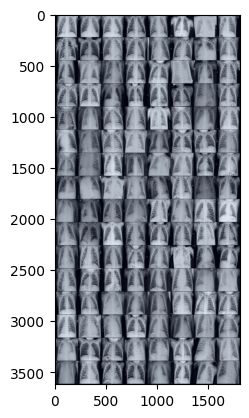

tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1])

In [13]:
def imshow(img):
    img = img #/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2,0)))
    plt.show()

dataiter = iter(train_loader)
batch = next(dataiter)
images, labels = batch

imshow(torchvision.utils.make_grid(images, normalize=True))
labels


In [14]:
print(f"Normal: {train_loader.dataset.targets.count(0)}, Pneumonia: {train_loader.dataset.targets.count(1)}")


Normal: 1341, Pneumonia: 3875


In [15]:
class PneumoniaScannerModel(torch.nn.Module):
    def __init__(self, num_classes=1):
        super(PneumoniaScannerModel, self).__init__()
        self.base_model = models.resnet50(weights="ResNet50_Weights.DEFAULT")

        for param in self.base_model.parameters():
            param.requires_grad = False

        num_out_ftrs = self.base_model.fc.out_features
        self.fc = torch.nn.Linear(num_out_ftrs, num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

model = PneumoniaScannerModel().to(device)


In [16]:
model_pickle_path = "../Model/PneumoniaScannerModel.pth"
learning_rate = 0.001
epochs = 20


In [17]:

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer with learning rate


In [18]:
neptune_run["criterion"] = str(torch.nn.BCELoss())
neptune_run["optimizer"] = str(torch.optim.Adam(model.parameters(), lr=learning_rate))
neptune_run["learning_rate"] = learning_rate
neptune_run["epochs"] = epochs
neptune_run["batch_size"] = batch_size
neptune_run["dataset_size"] = len(train_dataset)


In [19]:


for epoch in range(epochs):
    epoch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for image, target in epoch_pbar:
        optimizer.zero_grad()

        # changing the datatype and shape
        target = target.float().view(-1, 1)

        # loading to apple mps
        image = image.to(device)
        target = target.to(device)
        
        output = model(image)
        loss = criterion(output, target)
        
        predictions = (output > 0.5).float()

        target_np = target.cpu().detach().numpy().flatten()
        predictions_np = predictions.cpu().detach().numpy().flatten()

        # Calculate the number of correct predictions   
        correct_predictions += (predictions_np == target_np).sum()
        total_samples += target.size(0)

        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    neptune_run["Training/Epoch Loss"].log(avg_loss)
    neptune_run["Training/Epoch Accuracy"].log(accuracy)

    #epoch_pbar.set_postfix(loss=avg_loss, accuracy=accuracy)
    tqdm.write(f"Epochs: [{epoch+1}/{epochs}] | Train Loss: {avg_loss:.4f} | Train Accuracy: {accuracy:.4f}")

torch.save(model.state_dict(), model_pickle_path)

neptune_run.stop()


Epoch 1/20: 100%|██████████| 41/41 [04:04<00:00,  5.97s/batch]


Epochs: [1/20] | Train Loss: 0.3959 | Train Accuracy: 0.8409


Epoch 2/20: 100%|██████████| 41/41 [04:14<00:00,  6.20s/batch]


Epochs: [2/20] | Train Loss: 0.2662 | Train Accuracy: 0.8909


Epoch 3/20: 100%|██████████| 41/41 [05:20<00:00,  7.82s/batch]


Epochs: [3/20] | Train Loss: 0.2328 | Train Accuracy: 0.9041


Epoch 4/20: 100%|██████████| 41/41 [04:35<00:00,  6.73s/batch]


Epochs: [4/20] | Train Loss: 0.2107 | Train Accuracy: 0.9166


Epoch 5/20: 100%|██████████| 41/41 [05:48<00:00,  8.50s/batch]


Epochs: [5/20] | Train Loss: 0.1947 | Train Accuracy: 0.9264


Epoch 6/20: 100%|██████████| 41/41 [05:10<00:00,  7.57s/batch]


Epochs: [6/20] | Train Loss: 0.1814 | Train Accuracy: 0.9314


Epoch 7/20: 100%|██████████| 41/41 [04:51<00:00,  7.10s/batch]


Epochs: [7/20] | Train Loss: 0.1724 | Train Accuracy: 0.9358


Epoch 8/20: 100%|██████████| 41/41 [04:50<00:00,  7.09s/batch]


Epochs: [8/20] | Train Loss: 0.1677 | Train Accuracy: 0.9388


Epoch 9/20: 100%|██████████| 41/41 [04:23<00:00,  6.42s/batch]


Epochs: [9/20] | Train Loss: 0.1600 | Train Accuracy: 0.9398


Epoch 10/20: 100%|██████████| 41/41 [04:27<00:00,  6.51s/batch]


Epochs: [10/20] | Train Loss: 0.1534 | Train Accuracy: 0.9417


Epoch 11/20: 100%|██████████| 41/41 [23:24<00:00, 34.25s/batch]  


Epochs: [11/20] | Train Loss: 0.1551 | Train Accuracy: 0.9406


Epoch 12/20: 100%|██████████| 41/41 [04:17<00:00,  6.28s/batch]


Epochs: [12/20] | Train Loss: 0.1499 | Train Accuracy: 0.9427


Epoch 13/20: 100%|██████████| 41/41 [04:24<00:00,  6.44s/batch]


Epochs: [13/20] | Train Loss: 0.1474 | Train Accuracy: 0.9454


Epoch 14/20: 100%|██████████| 41/41 [04:08<00:00,  6.06s/batch]


Epochs: [14/20] | Train Loss: 0.1434 | Train Accuracy: 0.9450


Epoch 15/20: 100%|██████████| 41/41 [04:17<00:00,  6.27s/batch]


Epochs: [15/20] | Train Loss: 0.1424 | Train Accuracy: 0.9461


Epoch 16/20: 100%|██████████| 41/41 [04:06<00:00,  6.02s/batch]


Epochs: [16/20] | Train Loss: 0.1343 | Train Accuracy: 0.9503


Epoch 17/20: 100%|██████████| 41/41 [04:31<00:00,  6.63s/batch]


Epochs: [17/20] | Train Loss: 0.1352 | Train Accuracy: 0.9490


Epoch 18/20: 100%|██████████| 41/41 [04:33<00:00,  6.67s/batch]


Epochs: [18/20] | Train Loss: 0.1330 | Train Accuracy: 0.9525


Epoch 19/20: 100%|██████████| 41/41 [04:14<00:00,  6.21s/batch]


Epochs: [19/20] | Train Loss: 0.1328 | Train Accuracy: 0.9459


Epoch 20/20: 100%|██████████| 41/41 [04:22<00:00,  6.40s/batch]


Epochs: [20/20] | Train Loss: 0.1274 | Train Accuracy: 0.9525
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 2 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/jayasooryantm/xai-medical-imaging/e/XAIM-16/metadata
